# Computation of Persistence Diagrams and Fréchet Mean for Protein Sequences with ESM-2

This notebook demonstrates the process of computing persistence diagrams for protein sequences and their Fréchet mean using the ESM-2 model. We will compute context vectors for protein sequences using ESM-2, then convert these context vectors into a form suitable for computing persistence diagrams. Finally, we will compute the Fréchet mean of these persistence diagrams.


In [1]:
# Install the necessary Python packages

# numpy: a package for numerical computations in Python
# matplotlib: a plotting library in Python
# transformers: a library for transformer models in NLP
# gudhi: a library for topological data analysis
# scipy and sklearn: libraries for scientific computations and machine learning in Python

!pip install numpy matplotlib transformers gudhi scipy sklearn -q

## Definition of Protein Sequences


In [2]:
# Define the protein sequences

protein_sequences = [
    "VHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFF",
    "VHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFES",
    "VHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESF",
    "GLSDGEWQQVLNVWGKVEADIPGHGQEVLIRLFKGHPETLEKFDR"
]


## Computation of Context Vectors for Protein Sequences


In [3]:
# Import necessary libraries
from transformers import EsmModel, AutoTokenizer
import torch

def compute_context_vectors(protein_sequence, layer, head):
    # Load the tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
    model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")   

    # Tokenize input and convert to tensor
    inputs = tokenizer(protein_sequence, return_tensors="pt")

    # Forward pass
    outputs = model(**inputs, output_attentions=True, output_hidden_states=True)

    # Obtain the attention weights
    attentions = outputs.attentions

    # Obtain the attention weights for the specific layer and head
    S = attentions[layer][0, head]

    # Obtain the value vectors
    model.eval()
    with torch.no_grad():
        hidden_states = outputs.hidden_states[layer]
        all_W_v = model.encoder.layer[layer].attention.self.value.weight
        num_heads = model.config.num_attention_heads
        head_dim = model.config.hidden_size // num_heads
        W_v_heads = all_W_v.view(num_heads, head_dim, model.config.hidden_size)
        W_v = W_v_heads[head]
        V = torch.matmul(hidden_states, W_v.t())

    # Compute the output O
    O = torch.matmul(S, V)

    return O

# Set the layer and head to use for computation
layer = 3
head = 2

# Compute the context vectors for each protein sequence
context_vectors = [compute_context_vectors(seq, layer, head) for seq in protein_sequences]


Some weights of the model checkpoint at facebook/esm2_t6_8M_UR50D were not used when initializing EsmModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing EsmModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model chec

## Computation of Persistence Diagrams for Protein Sequences


In [5]:
from scipy.spatial import distance_matrix
import gudhi as gd
import numpy as np

def compute_persistence_diagram(context_vectors, protein_sequence):
    # Detach the tensor and convert to numpy array
    context_vectors_np = context_vectors[0].detach().numpy()

    # Compute the pairwise Euclidean distances among the context vectors
    distances = distance_matrix(context_vectors_np, context_vectors_np)

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)

    return persistent_homology

# Compute the persistence diagrams for each protein sequence
persistence_diagrams = [compute_persistence_diagram(context, seq) for context, seq in zip(context_vectors, protein_sequences)]


## Computation of the Fréchet Mean of Persistence Diagrams


In [7]:
from gudhi.wasserstein.barycenter import lagrangian_barycenter

def convert_persistence_diagram(diagram, dimension):
    return np.array([point[1] for point in diagram if point[1][1] != np.inf and point[0] == dimension])

# Convert the persistence diagrams to the appropriate format
converted_diagrams = [convert_persistence_diagram(diag, 1) for diag in persistence_diagrams]

# Compute the Fréchet mean of the persistence diagrams
frechet_mean = lagrangian_barycenter(pdiagset=converted_diagrams, init=0)

print("Fréchet mean of the persistence diagrams:")
print(frechet_mean)


Fréchet mean of the persistence diagrams:
[[0.1019498  0.12332781]
 [0.08684006 0.09949496]
 [0.07449247 0.08628009]
 [0.10522105 0.10783894]
 [0.09807877 0.1007339 ]
 [0.08884561 0.09302715]
 [0.07123579 0.07324044]
 [0.07947653 0.08141049]
 [0.08064701 0.0822148 ]
 [0.06087262 0.06149911]
 [0.09250238 0.09664686]
 [0.10109362 0.10325347]
 [0.05193209 0.05452511]
 [0.05545235 0.05710111]
 [0.08130216 0.08294133]
 [0.05534306 0.05575815]
 [0.05091841 0.05128485]]


## Visualization of Persistence Diagrams and Their Fréchet Mean


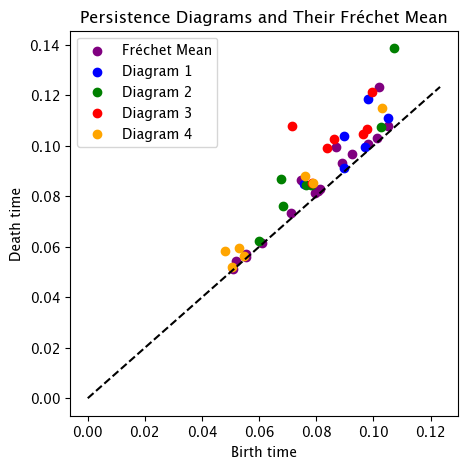

In [9]:
import matplotlib.pyplot as plt

# Convert the Fréchet mean back into a list of tuples format for plotting
frechet_mean_as_tuples = [(1, tuple(point)) for point in frechet_mean]

# Separate birth and death times for plotting
birth_times_frechet, death_times_frechet = zip(*[point[1] for point in frechet_mean_as_tuples])

plt.figure(figsize=(5,5))

# Plot the Fréchet mean
plt.scatter(birth_times_frechet, death_times_frechet, color='purple', label='Fréchet Mean')

# Plot the original diagrams
colors = ['blue', 'green', 'red', 'orange']
for idx, diag in enumerate(converted_diagrams):
    birth_times, death_times = zip(*diag)
    plt.scatter(birth_times, death_times, color=colors[idx], label=f'Diagram {idx+1}')

plt.plot([0, max(death_times_frechet)], [0, max(death_times_frechet)], 'k--')  # diagonal line
plt.title('Persistence Diagrams and Their Fréchet Mean')
plt.xlabel('Birth time')
plt.ylabel('Death time')
plt.legend()
plt.show()


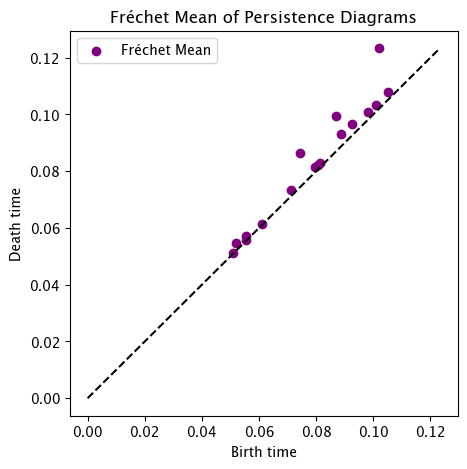

In [11]:
import matplotlib.pyplot as plt

# Convert the Fréchet mean back into a list of tuples format for plotting
frechet_mean_as_tuples = [(1, tuple(point)) for point in frechet_mean]

# Separate birth and death times for plotting
birth_times_frechet, death_times_frechet = zip(*[point[1] for point in frechet_mean_as_tuples])

plt.figure(figsize=(5,5))

# Plot the Fréchet mean
plt.scatter(birth_times_frechet, death_times_frechet, color='purple', label='Fréchet Mean')

plt.plot([0, max(death_times_frechet)], [0, max(death_times_frechet)], 'k--')  # diagonal line
plt.title('Fréchet Mean of Persistence Diagrams')
plt.xlabel('Birth time')
plt.ylabel('Death time')
plt.legend()
plt.show()
